In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from scipy.signal import find_peaks


# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [3]:
j = janet.boot(uni, index=24)

Already have data downloaded for Gaia ID 3296334520042680064.
If you want to check for new data, run `janet.update()`.
No postcard object will be created for this target.
### Running Simple Astropy Lomb-Scargle on Sector 5 on star 3296334520042680064 ###
### Completed Simple Astropy Lomb-Scargle for Sector 5 on star 3296334520042680064 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 32 on star 3296334520042680064 ###
### Completed Simple Astropy Lomb-Scargle for Sector 32 on star 3296334520042680064 ###
### Saved results ###
### Running Wavelet Estimation on star 3296334520042680064 ###


/Users/Anaconda/anaconda3/envs/michael/lib/python3.8/site-packages/jazz_hands-0.0.3-py3.8.egg/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

### Completed Wavelet Estimation on star 3296334520042680064 ###
### Saved results ###
### Running ACF Estimation on star 3296334520042680064 ###
### Completed ACF Estimation on star 3296334520042680064 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###


/Users/oliver hall/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/oliver hall/Research/michael/Examples/../michael/plotting.py:332: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{j.output_path}/{j.gaiaid}/output.pdf', rasterized=True)



------ Decoding Overall Period Flag 1 ------
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


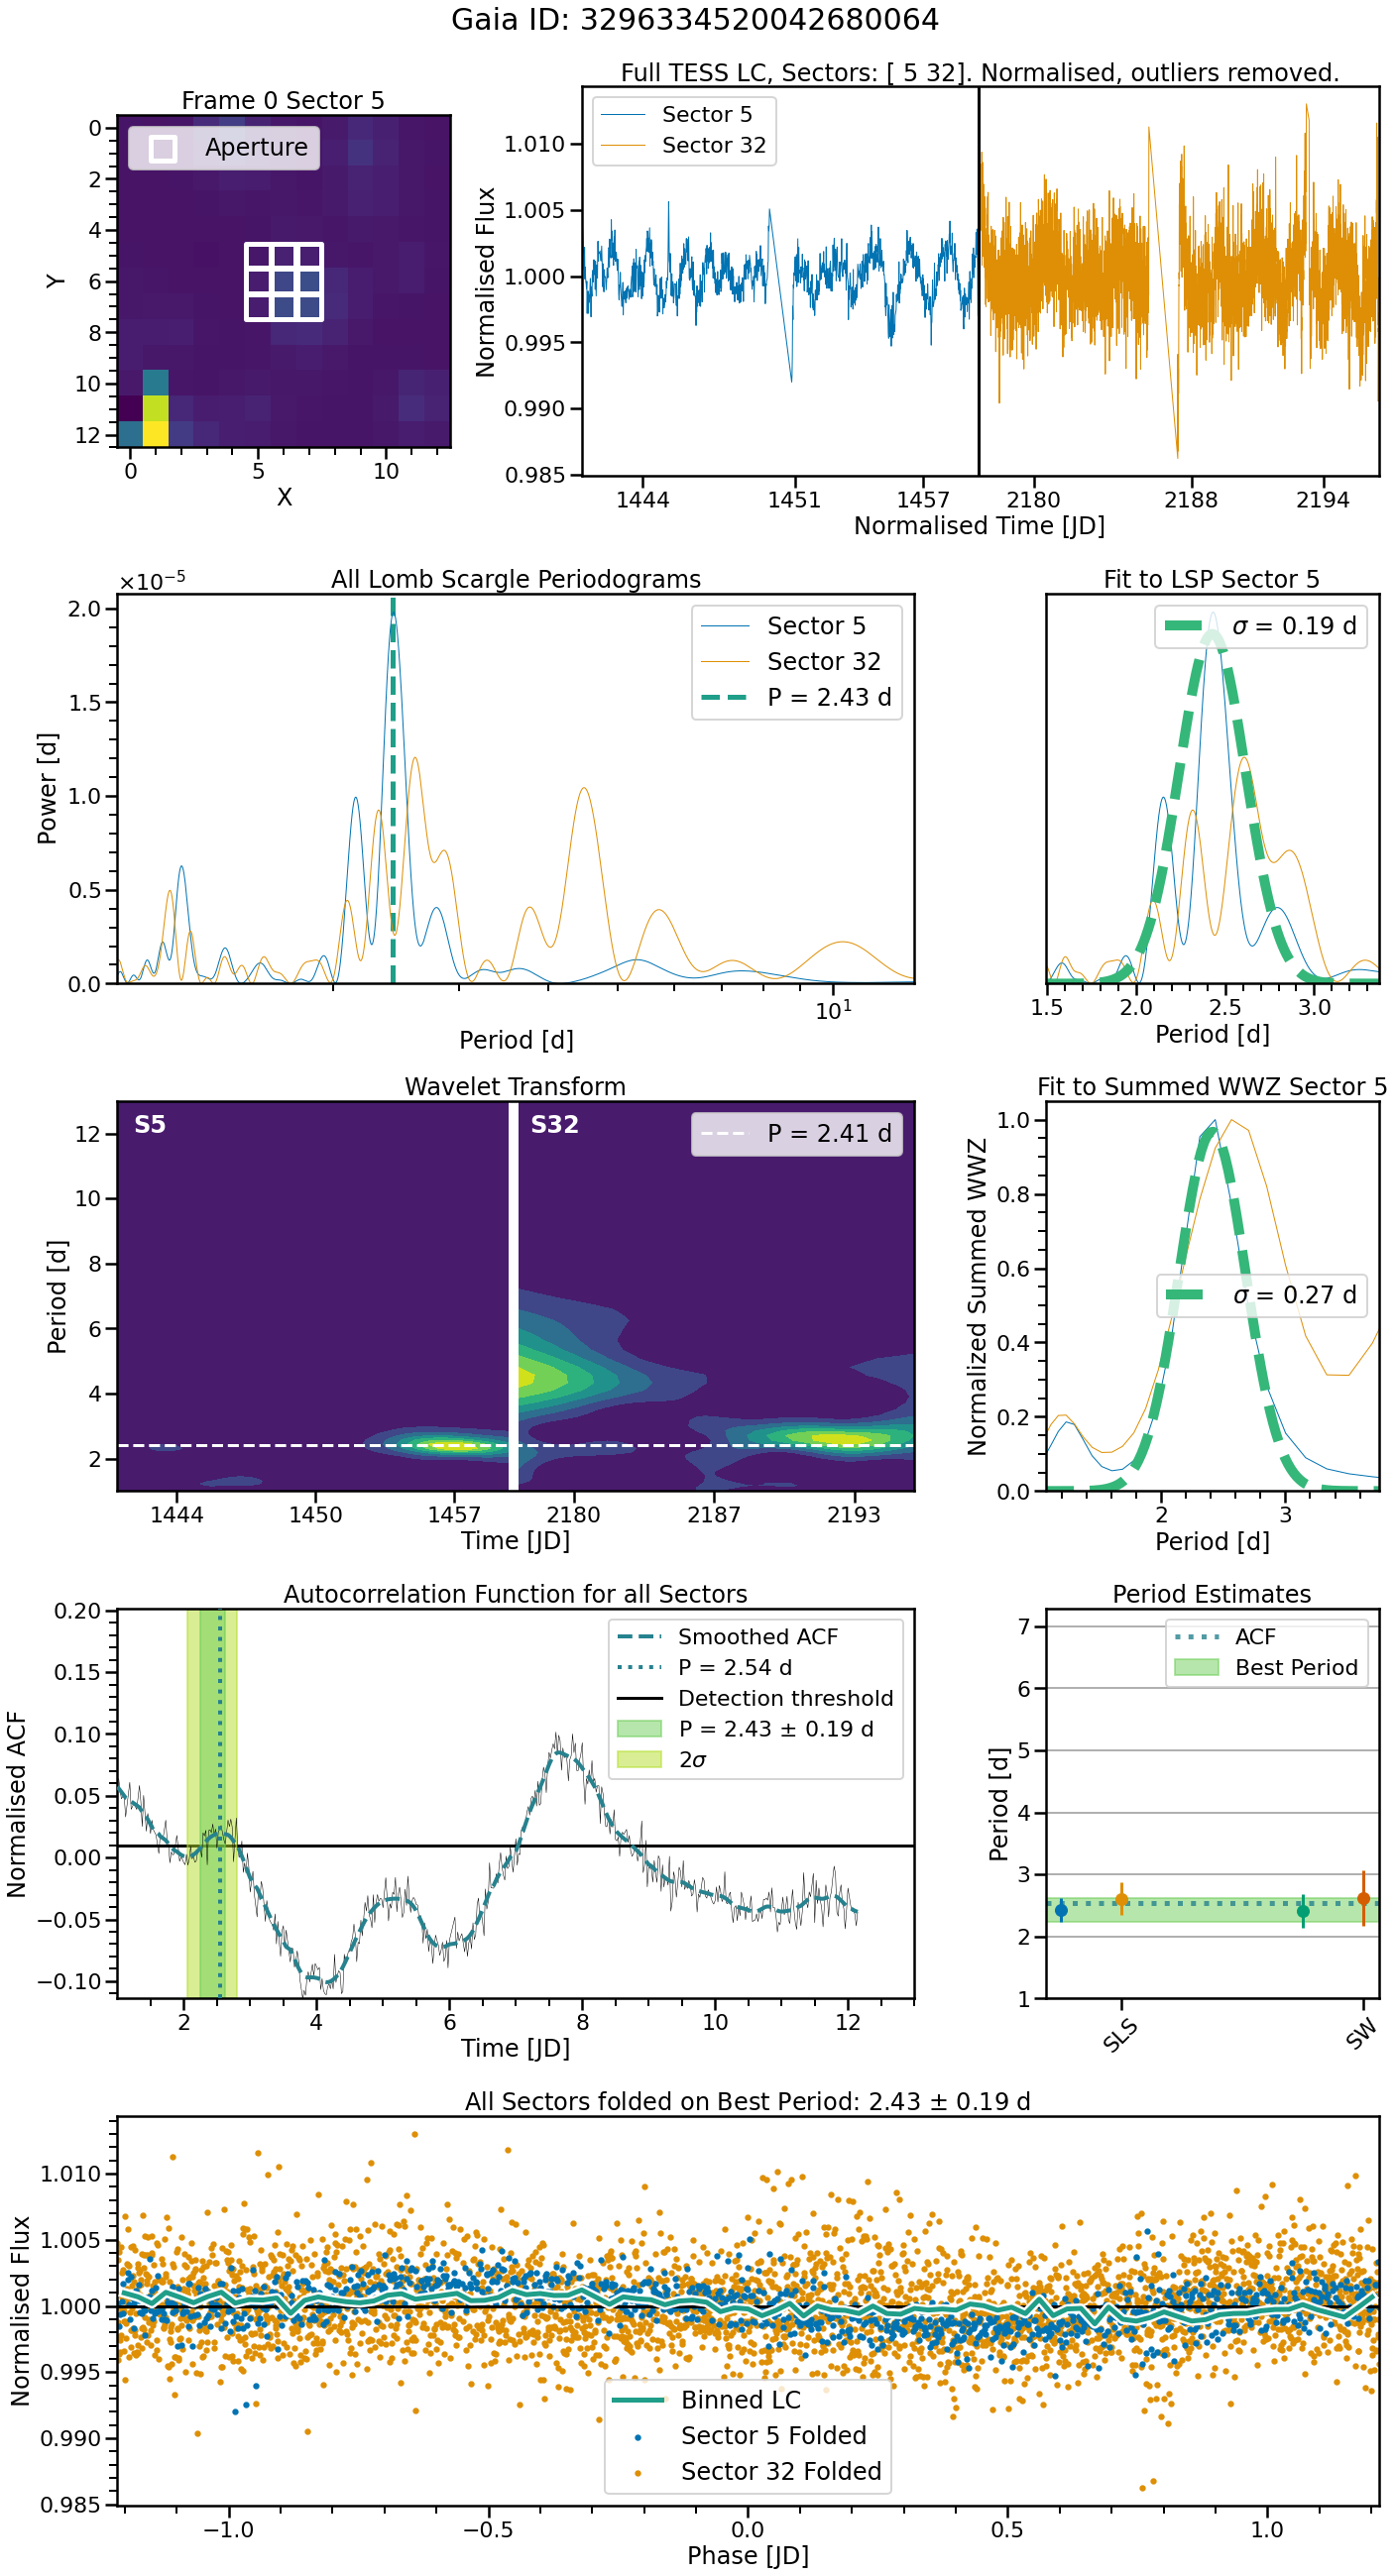

In [4]:
j.run(period_range = (1, 13))

In [7]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW,ACF,s_SLS,s_SW,overall,e_overall,f_overall
5,2.428697,0.186747,0.0,2.41144,0.268079,NaN,NaN,NaN,NaN,NaN,NaN
32,2.607323,0.260732,0.0,2.61744,0.452918,NaN,NaN,NaN,NaN,NaN,NaN
all,NaN,NaN,NaN,NaN,NaN,2.54175,NaN,NaN,NaN,NaN,NaN
best,2.428697,0.186747,0.0,2.41144,0.268079,NaN,5,5,2.428697,0.186747,1.0


In [18]:
type(j.results.index[0])

int

In [23]:
list(j.sectors.astype(int))

[5, 32]

In [32]:
res = j.results.loc[j.sectors.astype(int), ['SLS','SW']].to_numpy().flatten()
err = j.results.loc[j.sectors.astype(int), ['e_SLS', 'e_SW']].to_numpy().flatten()

In [35]:
up = 1.5*np.nanmax(res+err)
do = 0.5*np.nanmax(res-err)

In [36]:
up

4.605536951367776

Adding new features

In [ ]:
acfsmoo = j.void['acfsmoo']
wt = j.void['wt']
nus = wt.nus
wwz = j.void['wwz']

In [ ]:
acfsmoolc = lk.LightCurve(time = j.void['acflc'].time.value, flux = acfsmoo)

In [ ]:
Model = pm.Model()
P = acfsmoolc.time.value
F = acfsmoolc.flux.value

with Model:
    A0 = pm.Uniform('A0', 0., 1., testval=0.05)
    A1 = pm.Uniform('A1', 0., 10., testval=0.5)
    yy = pm.Deterministic('yy', (1-A0)*np.exp(-P/A1) + A0)
    y = pm.Normal('like', mu=yy, sigma = np.std(F),
                 observed=F)

In [ ]:
with Model:
    trace = pm.sample()

In [ ]:
yy = np.median(trace['yy'], axis=0)
normacf = acfsmoolc - yy

In [ ]:
binned = normacf.bin()